# Model 02 - Support Vector Classifier

In [0]:
# Standard imports
import numpy as np
import pandas as pd

# Seed random number generator for consistent OPs across runs
np.random.seed(42)

# Matplotlib styles
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')

# Seaborn for distributions
from seaborn import distplot
from seaborn import light_palette # For confusion matrix color coding

# Linear and Non-Linear Support Vector Classifiers
from sklearn.svm import LinearSVC, SVC

# Sckikit metrics for classification and coring 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, \
confusion_matrix, average_precision_score, make_scorer, plot_confusion_matrix

# Scikit cross validation, splitting, and grid search methods
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split

# For defining custom transformer classes in a pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Needed in feature scaler transformer
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler, RobustScaler

# For manipulating files within CoLab
import os

# No warnings pls
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
fyp_dir = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection'
data_dir = 'Data'
data_file = 'data-final.csv'
data_path = os.path.join(fyp_dir, data_dir, data_file)
print(data_path)

/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/data-final.csv


In [0]:
data = pd.read_csv(data_path)

In [0]:
# Targets - class labels for all training samples
y = data['FLAG'].values

In [0]:
X = data.iloc[:, 2:].values

In [0]:
# Is there one training sample per label?
assert X.shape[0] == y.shape[0]

## Stratified Sampling

In [0]:
# Test Size = 1 - Training Ratio
TEST_SIZE = 0.20

In [0]:
# Shuffling data and making sure both training and test sets contain same proportion of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

## Helper Function Definitions

In [0]:
def get_classification_result(y_pred, y_true, classifier_name=None):
    """Custom function to display classification results"""
    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves']))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    conf_mat = pd.DataFrame(data=confusion_matrix(y_true, y_pred))
    conf_mat.index = ['True 0', 'True 1']
    conf_mat.columns = ['Predicted 0', 'Predicted 1']
    cm = light_palette('blue', as_cmap=True)
    conf_mat_display = conf_mat.style.background_gradient(cmap=cm)
    display(conf_mat_display)
    
    # Display ROC 
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr) 
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right')
    
    if classifier_name is not None:
        plt.title(f'ROC Curve - {classifier_name}', fontsize=14)

In [0]:
def visualizeCVResults(cv_obj, model_name=None, metric='auc', figsize=(12, 6)):
  # First, convert to dataframe
  cvResults = pd.DataFrame(cv_obj.cv_results_)
  if metric=='auc':
      # Drop unnecessary columns
      newResults = cvResults[['rank_test_roc_auc_scorer', 'params', 'mean_test_roc_auc_scorer',
                           'std_test_roc_auc_scorer']]
  
      # Then, sort by rank - highest score comes first
      newResults.sort_values(by=['rank_test_roc_auc_scorer'], inplace=True, ascending=True)
  else:
      newResults = cvResults[['rank_test_map_scorer', 'params', 'mean_test_map_scorer', 
                             'std_test_map_scorer']]
      # Then, sort by rank - highest score comes first
      newResults.sort_values(by=['rank_test_map_scorer'], inplace=True, ascending=True)

  # Rename the columns for easier referencing, regardless of metrics
  newResults.columns = ['rank_test_score', 'params', 'mean_test_score', 'std_test_score']

  # Create a bar graph

  # Make a figure
  plt.figure(figsize=figsize)

  # One bar for each model being compared, so one tick for each bar
  xtick_range = list(range(0, len(newResults)))

  # Label for the ticks will be the parameters
  xtick_labels = newResults['params']

  # Plot the bar graph
  plt.bar(xtick_range, height=newResults['mean_test_score'])

  # Replace the tick labels with parameter values
  plt.xticks(xtick_range, xtick_labels, rotation='vertical')

  # Annotate
  plt.xlabel('Parameters', fontsize=14)
  y_label_str = 'Mean CV AUC' if metric is 'auc' else 'Mean CV AP'
  plt.ylabel(y_label_str, fontsize=14)
  title_str = y_label_str + ' - '  + model_name if model_name is not None else y_label
  plt.title(title_str, fontsize=18)

## Transformers

In [0]:
# Creating a custom transformer 
class MyFeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scalingStrategy='StandardScaler'):
        """Initialize this transformer with an instance of the scaler you wish to use"""
        # Initialise dictionary of all possible scaling strategies
        self.scalingStrategies = {
            'StandardScaler': StandardScaler(),
            'MinMaxScaler': MinMaxScaler(),
            'MaxAbsScaler': MaxAbsScaler(),
            'RobustScaler': RobustScaler(),
            'ScaleByConsumer': Normalizer(),
        }
        self.scaler = self.scalingStrategies[scalingStrategy]
        
    def fit(self, X, y=None):
        # Do nothing for now
        return self.scaler.fit(X, y)
    
    def transform(self, X, y=None):
        scaled_features = self.scaler.transform(X, y)

In [0]:
class Transposer(BaseEstimator, TransformerMixin):
  """Transposes a matrix of features"""
  def __init__(self):
    # Do nothing for now
    pass

  def fit(self, X, y=None):
    # Do nothing for now 
    return self

  def transform(self, X, y=None):
    return X.transpose()

## Pipelines

In [0]:
pipeline_zheng = Pipeline([
                           ('FeatureScaler', MyFeatureScaler())
])

In [0]:
pipeline_custom = Pipeline([
                            ('Transposer', Transposer()),
                            ('FeatureScaler', MyFeatureScaler()),
                            ('Retransposer', Transposer())
])

## Cross Validation Scoring Functions

In [0]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
avg_precision_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=False)

## Zheng's Support Vector Classifier

Zheng's paper has specified the following hyperparameters for the support vector machine.
1. Penalty parameter of error term: 1.0
2. Kernek: `rbf` - Radial Basis Function

No other specifics have been provided. Assuming standard scaling using mean and standard deviation of kWh values of a single consumer. 

Further assuming that it is `SVC` and not `LinearSVC`.

In [0]:
# Instantiate a new model with the specified parameters
svc_zheng = SVC(C=1.0, kernel='rbf', random_state=0, probability=False)

In [28]:
# Cross validate on 5 folds of the training set 
svc_zheng_results = cross_validate(estimator=svc_zheng, 
                                   X=pipeline_zheng.fit_transform(X_train), 
                                   y=y_train, 
                                   scoring = {
                                       'roc_auc_scorer': roc_auc_scorer,
                                       'map_scorer': avg_precision_scorer,
                                       }, 
                                   n_jobs=1,
                                   verbose=2,
                                   cv=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total= 5.0min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.0min remaining:    0.0s


[CV] ................................................. , total= 4.8min
[CV]  ................................................................
[CV] ................................................. , total= 4.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.8min finished


In [30]:
svc_zheng_results

{'fit_time': array([226.40127611, 220.85081792, 225.48551989]),
 'score_time': array([71.6577208 , 69.52662897, 71.37704825]),
 'test_map_scorer': array([0.08617762, 0.0865234 , 0.08721497]),
 'test_roc_auc_scorer': array([0.50094059, 0.50098897, 0.50103734])}

Something is wrong. The ROC AUC score should not be ~50. It should be much higher. In Zheng's paper, Support Vector Classifiers gave the best performance of all shallow learning models. 

## Hyperparameter Tuning - Linear SVC

In [0]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 5),
    'fit_intercept': [True, False],
    # 'loss': ['hinge', 'squared_hinge']
}

In [0]:
svcLinear_clf = LinearSVC(random_state=0)

In [0]:
gridSearchCV_svc_linear = GridSearchCV(
    estimator=svcLinear_clf, 
    param_grid=param_grid, 
    scoring = {
        'roc_auc_scorer': roc_auc_scorer,
        'map_scorer': avg_precision_scorer,
    }, 
    n_jobs=1, 
    cv=3,
    verbose=3, 
    refit='roc_auc_scorer'
)

In [0]:
gridSearchCV_svc_linear.fit(pipeline_custom.fit_transform(X_train), 
                            y_train)

In [0]:
import pickle

In [0]:
best_svc_linear_model = gridSearchCV_svc_linear.best_estimator_

In [0]:
pickle.dump(best_svc_linear_model, open('best_svc_linear_model.sav', 'wb'))

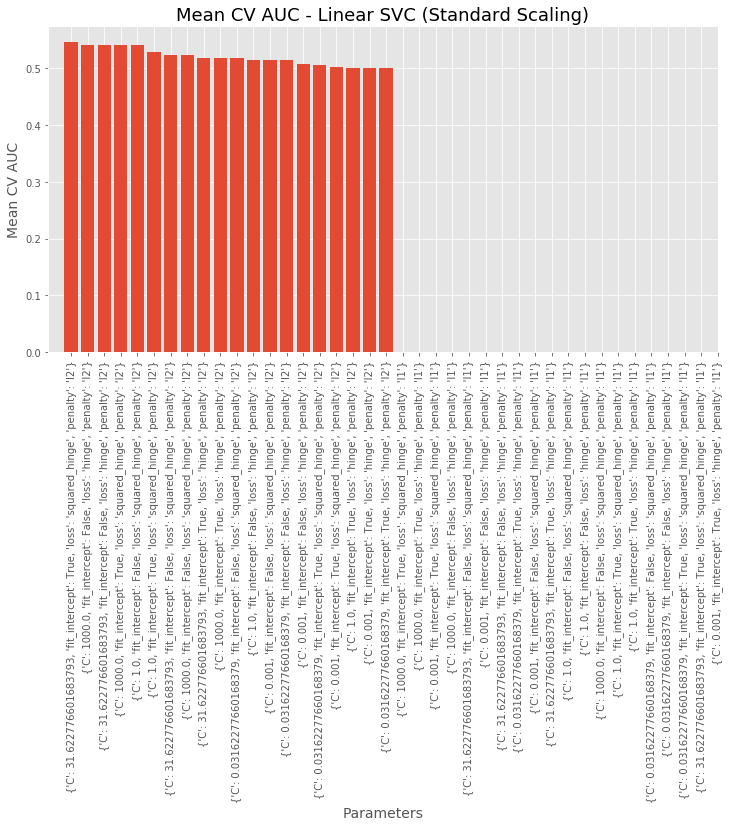

In [47]:
visualizeCVResults(gridSearchCV_svc_linear, model_name='Linear SVC (Standard Scaling)', 
                   metric='auc')